## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from implementations.mcmc_l1 import sample

In [2]:
RANDOM_SEED = 2022
rng = np.random.default_rng(RANDOM_SEED)

## Data loading

In [3]:
f = open("./data/spambase.columns", "r")
headers = [line.split(":")[0] for line in f]+["class"]

df = pd.read_csv("./data/spambase.data", header=None) 
df.columns = headers
df.insert(0, "intercept", 1)
df["class"] = df["class"].replace(0,-1)

df.sample(5)

,intercept,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
2640,1,0.0,0.39,0.19,0.0,0.19,0.09,0.0,0.0,0.0,...,1.352,0.080,0.0,0.016,0.0,0.0,1.679,17,178,-1
4468,1,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,...,0.000,0.554,0.0,0.000,0.0,0.0,2.294,15,39,-1
4147,1,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,...,0.000,2.263,0.0,0.000,0.0,0.0,3.149,9,1310,-1
3906,1,2.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.0,0.0,5.888,29,53,-1
3077,1,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,...,0.000,0.220,0.0,0.000,0.0,0.0,2.000,12,34,-1


In [4]:
# Compute X by multiplying each row by the class
X = np.array(df.drop('class', axis=1)) * np.array(df["class"]).reshape(-1,1)

In [5]:
# Number of samples and of dimensions
n, k = X.shape
n, k

(4601, 58)

In [6]:
# Compute variance matrix
sigma = df.drop('class', axis=1).std(axis=0)
sigma[0] = 1
sigma.shape

(58,)

## Study

In [7]:
n_chains = 3
T = 100
n_start = 20 # burn in

In [8]:
nu = 1

betas1 = np.zeros((T,k))

for _ in range(n_chains):
    betas1 += sample(X, sigma, rng, nu, T)

betas1 /= n_chains
betas1 = betas1[n_start:]
std_betas1 = betas1.mean(axis=0)*sigma

/home/mark/m2ds/bml/bml-project/implementations/mcmc_l1.py:61: RuntimeWarning: covariance is not positive-semidefinite.
  betas[t][omegas_idx] = rng.multivariate_normal(b, cov=B)


In [9]:
nu = 1e-3

betas2 = np.zeros((T,k))

for _ in range(n_chains):
    betas2 += sample(X, sigma, rng, nu, T)

betas2 /= n_chains
betas2 = betas2[n_start:]
std_betas2 = betas2.mean(axis=0)*sigma

In [10]:
lower_bound1 = np.quantile(betas1, 0.025, axis = 0)
lower_bound2 = np.quantile(betas2, 0.025, axis = 0)

upper_bound1 = np.quantile(betas1, 1-0.025, axis = 0)
upper_bound2 = np.quantile(betas2, 1-0.025, axis = 0)

err1 = upper_bound1-lower_bound1
err2 = upper_bound2-lower_bound2

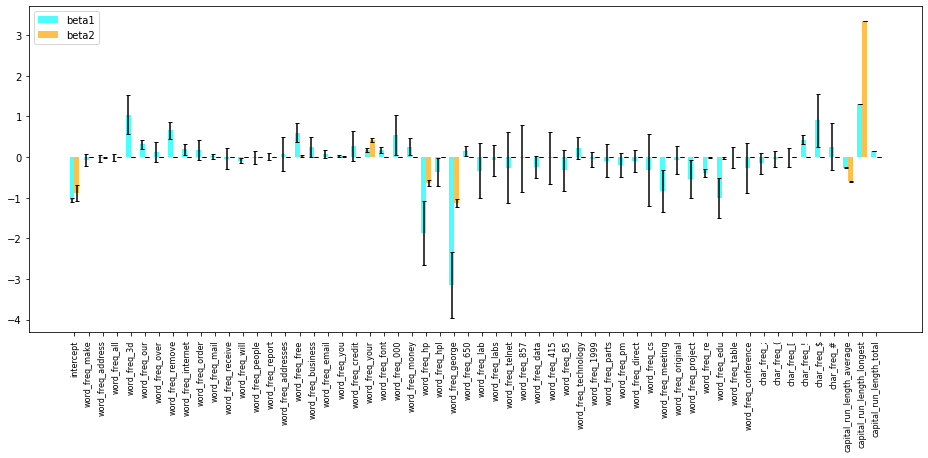

In [11]:
x = np.arange(k)
width = 0.35

fig, ax = plt.subplots(figsize=(16, 6))
bar1 = ax.bar(x - width / 2, std_betas1, width, label='beta1', alpha=.7, yerr=err1, capsize=2, color="cyan")
bar2 = ax.bar(x + width / 2, std_betas2, width, label='beta2', alpha=.7, yerr=err2, capsize=2, color="orange")

ax.set_xticks(x)
ax.set_xticklabels(df.columns[:-1], fontsize=8)

plt.xticks(rotation=90)
# plt.yscale("log")
plt.legend()
plt.show()